# compare two model using F-test
model1: $y(t) = ky(t-h) + x(t)\beta + \epsilon$ 

model2: $y(t) = ky(t-h) + \epsilon$

In [1]:
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

# sns.set_theme(style="whitegrid")
sns.despine(offset=10, trim=True)

ROOT = "/work/"
DATA_ROOT = ROOT/Path('data/alldata/')
OUTPUT_ROOT = ROOT/Path("output/")

datalist = np.array([x for x in DATA_ROOT.iterdir()])
output_dir = OUTPUT_ROOT/"ridge_regression/"

<Figure size 640x480 with 0 Axes>

In [41]:
def get_RSS(results_all: list, nthist: int, axis: str):
    """Get RSS and degree of freedom."""
    filtered_result = [result for result in results_all if (result["nthist"]==nthist)and(result["coord_axis"]==axis)][0]
    rss = filtered_result['sig_tests'].RSS
    df = filtered_result['sig_tests'].df_model
    return rss, df

def cal_f_stat(rss1, rss2, df1, df2):
    """Cal the F statistics and corresponding p-value."""
    tmp1 = (rss2 - rss1)/df2
    tmp2 = rss1/df1
    f_stat = tmp1/tmp2
    return f_stat, stats.f.sf(f_stat, df2, df1)

def gen_df(data_dir):
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "knockout" if "CaMKII" in data_name else "wild-type"

    # spikes+ past coord
    with open(output_dir/(f"rr_spikes_past_coord_eval_{data_name}.pickle"),"rb") as f:
        sp_results_all = pickle.load(f)
    # only past-coord
    with open(output_dir/(f"rr_only_past_coord_eval_{data_name}.pickle"),"rb") as f:
        op_results_all = pickle.load(f)

    f_p_list = []
    f_stat_list = []
    for nthist in np.arange(1,30):
        axis = "x-axis"
        rss1, df1 = get_RSS(sp_results_all ,nthist, axis)
        rss2, df2 = get_RSS(op_results_all ,nthist, axis)
        f_stat, f_p_value = cal_f_stat(rss1, rss2, df1, df2)
        f_p_list.append(f_p_value)
        f_stat_list.append(round(f_stat, 2))
    df = pd.DataFrame({
        "num of history time bins": np.arange(1,30),
        "F test p value": f_p_list,
        "F statistics": f_stat_list
        })
    return df

## Visualization

### representatives

wild-type
knockout


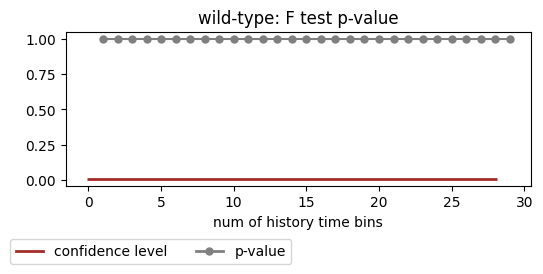

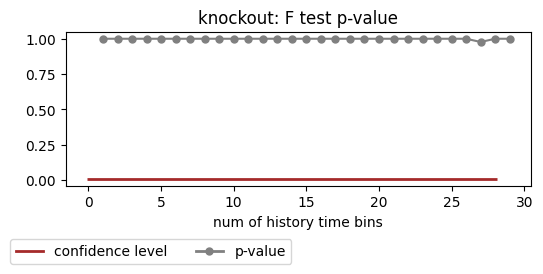

In [36]:
for data_dir in datalist[[2,0]]:
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "knockout" if "CaMKII" in data_name else "wild-type"
    df = gen_df(data_dir)
    fig, ax = plt.subplots(figsize=(6,2))
    df.set_index("num of history time bins")[["F test p value"]].plot(ax=ax, color="gray", marker="o", markersize=5)
    ax.hlines(y=.01, xmin=min(df.index)-.1, xmax=max(df.index)+.1, colors="brown", lw=2)
    ax.get_legend().remove()
    ax.set_title(f"{mouse_type}: F test p-value")

    legend_elements = [
                    Line2D([0], [0], lw=2, label='confidence level', color='brown'),
                    Line2D([0], [0], lw=2, label='p-value', color='gray', marker='o', markersize=5)
                    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(.5,-.3), ncol=2)
    


### all mice

Text(0.5, 0.98, 'confidence level:0.01')

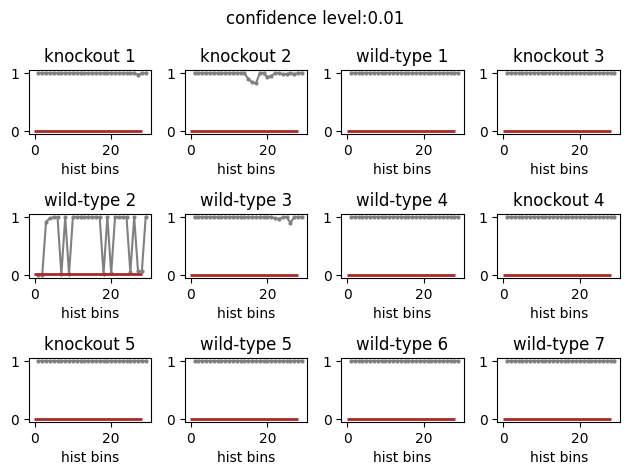

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=4, tight_layout = True)
axes = axes.ravel()
ko_id, wt_id = 0, 0
conf_level = .01
for mouse_id, data_dir in enumerate(datalist):
    ax = axes[mouse_id]
    data_name = str(data_dir).split('/')[-1]
    if "CaMKII" in data_name:
        mouse_type = "knockout" 
        ko_id += 1
        ax.set_title(f"{mouse_type} {ko_id}")
    else:
        mouse_type = "wild-type"
        wt_id += 1
        ax.set_title(f"{mouse_type} {wt_id}")
    df = gen_df(data_dir)
    df.set_index("num of history time bins")[["F test p value"]].plot(ax=ax, color="gray", marker="o", markersize=2)
    ax.hlines(y=conf_level, xmin=min(df.index)-.1, xmax=max(df.index)+.1, colors="brown", lw=2)
    ax.get_legend().remove()
    ax.set_xlabel("hist bins")
plt.suptitle(f"confidence level:{conf_level}")
    
